In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import all csvs
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

# Perform Data Exporation

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Inspect Data & Find Anomolies

<AxesSubplot:>

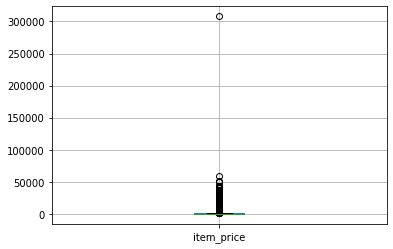

In [8]:
# This box plot shows distinct outliers (e.g., > 10000, < 0)
sales.boxplot(column=['item_price'])

In [9]:
# correct the anomolies
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

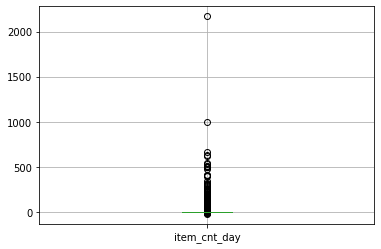

In [11]:
# This box plot shows distinct outliers (e.g., > 750, < 0) - where < 0 may be thought of as returns/refunds
sales_train.boxplot(column=['item_cnt_day'])

In [12]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

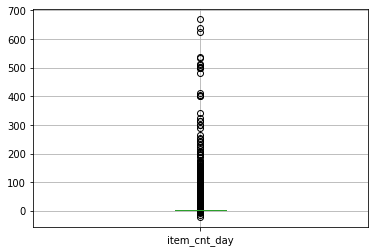

In [13]:
sales_train.boxplot(column=['item_cnt_day'])

# Items Data Prep. & Feature Engineering

In [14]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [15]:
# merge items and item_categories data set on 'item_category_id' to begin crafting
# complete data set
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [16]:
# generate a feature called 'genre' to categorize into categories and subcategories
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [17]:
# adjust some anomolies in the dataset and re-perform feature computation
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [18]:
# OneHotEncoding - take categories and convert them to numerical data
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [19]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [20]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [21]:
# correct duplicate shops - access a group of rows and columns by labels
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40

# check the amount of unique shops and compare number of unique entires in sales_train dataset
rows = len(sales_train)
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print(rows - len(sales_train))

502311


In [22]:
# begin adding sales train info
# we want to aggregate all the sales count by month instead of days so that we can view trends in the dataset

# ('date_block_num','shop_id','item_id') provides a unique primary key to access each tuple in the data set.
aggregate_count = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
aggregate_count.columns = ['item_cnt_month']
aggregate_count.reset_index(inplace=True)

aggregate_count.head(1000500)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1000495,23,46,17818,1.0
1000496,23,46,17865,3.0
1000497,23,46,17866,1.0
1000498,23,46,17867,1.0


In [23]:
#aggregate_days_sold = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']})
#aggregate_days_sold.columns = ['days_sold']
#aggregate_days_sold.reset_index(inplace=True)
#aggregate_days_sold.head() 

#cc = aggregate_days_sold.loc[aggregate_days_sold['days_sold'] > 31]
#cc.head()

In [24]:
# now that we have the total monthly sales, we want to determine average price per month

aggregate_price = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
aggregate_price.columns = ['mean_price']
aggregate_price.reset_index(inplace=True)

aggregate_price.head()

,date_block_num,shop_id,item_id,mean_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [25]:
# we will now perform left join on the data set so that we can combine the two metrics we computed above
merged = aggregate_count.merge(aggregate_price, on=['date_block_num','shop_id','item_id'], how='left')
merged.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


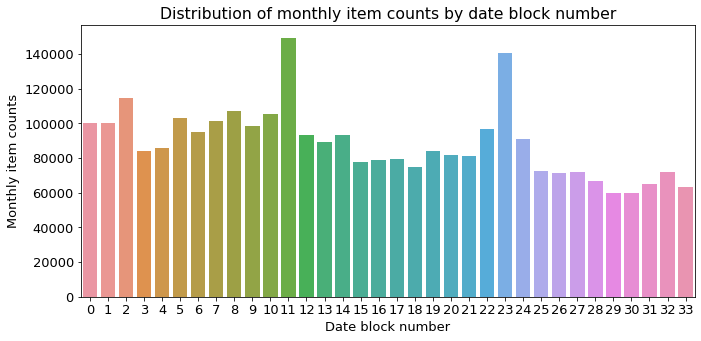

In [26]:
# plot item counts against each month (0-33 months)
# we can see how months 11 + 23 (December) show a spike in sales

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
# group by date, provide sum of item count
group_month_sum = merged.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

In [27]:
# append to test data set & set data types
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
# concatenate current dataset and test dataset
merged = pd.concat([merged, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merged.fillna(0, inplace=True)


In [28]:
mx = merged.loc[merged['date_block_num'] == 34]
print(len(mx))
mx.head()
print(len(test))


214200
214200


In [29]:
# now, include the items dataset and merge on item id
merged2 = merged.merge(items, on=['item_id'], how='left')
# we also now add shop name for city feature
merged2 = merged2.merge(shops, on='shop_id')
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран"


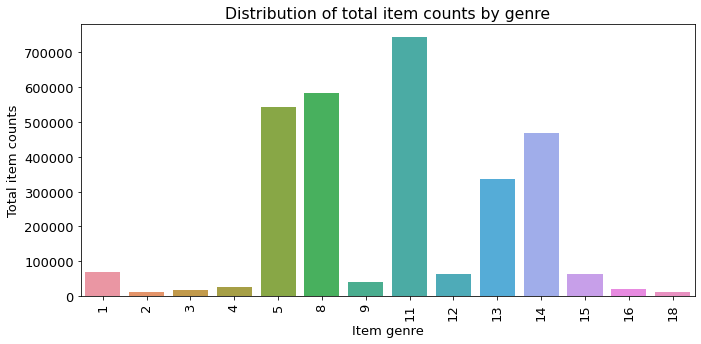

In [30]:
# here, we plot the distribution of total item counts by genre

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = merged2.groupby('genre_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='genre_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by genre',
       xlabel='Item genre', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

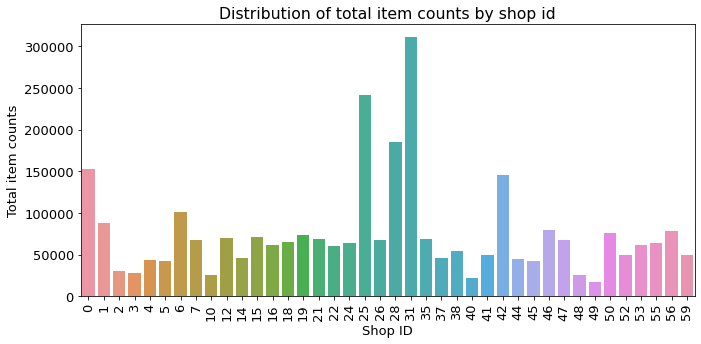

In [31]:
# plot distribution of total item counts by shop ID

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = merged2.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

In [32]:
# normalize month into 1-12 format instead of 0-33
merged2["month_id"] = merged2['date_block_num'].apply(lambda dbn: 1 + dbn % 12)
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1


In [33]:
# select may, for example, and let's now inspect for trends during the days of the month
month_inspection = sales_train.loc[sales_train["date_block_num"] == 5]
month_inspection = month_inspection.groupby(['date']).agg({'item_cnt_day': ['sum']})
month_inspection = month_inspection.reset_index()

month_inspection["date"] = month_inspection['date'].apply(lambda x: int(x.split('.')[0]) )
month_inspection.head(5)

,date,item_cnt_day
,,sum
0,1,4823.0
1,2,3663.0
2,3,2733.0
3,4,2753.0
4,5,2892.0


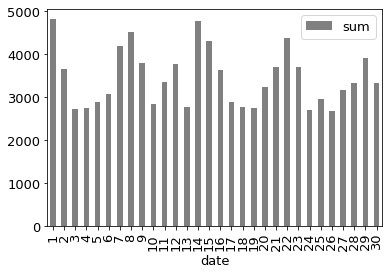

In [34]:
# here, we are able to see that weekends correlate with more sales.
month_inspection.plot.bar(x="date", y="item_cnt_day", color='grey');

In [35]:
# given a month, compute the number of weekends so that we can use as an additional feature
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    return weeknd_count
map_dict = {i: count_days(i) for i in range(35)}

merged2['weeknd_count'] = merged2['date_block_num'].apply(lambda x: map_dict[x])
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id,weeknd_count
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1,4
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1,4


In [36]:
# lagging is a critical feature for our training process.
# it allows for model to look back in time and see how the shop performed in the months before.
# currently, we are looking up to 3 months back
def lag_feature(df, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in [1, 2, 3]:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    del tmp
    return df

In [37]:
merged2 = lag_feature(merged2, 'item_cnt_month')
merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']] = merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].fillna(value=0)

In [38]:
# let's take a look here and now we can see we have counts for the number of items sold
# 1 month before, 2 months before, and 3.
merged2.head(500000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,34,19,10954,0.0,0.0,99303.0,37,11,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0
499996,34,19,10945,0.0,0.0,99304.0,57,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0
499997,34,19,10942,0.0,0.0,99305.0,55,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,1.0
499998,34,19,10940,0.0,0.0,99306.0,58,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0


In [39]:
# create feature city based on location of shop
merged2['city'] = merged2['shop_name'].apply(lambda x: x.split()[0].lower())
merged2.loc[merged2.city == '!якутск', 'city'] = 'якутск' # correct for error
merged2['city_code'] = LabelEncoder().fit_transform(merged2['city'])
merged2 = merged2.drop(columns=['city', 'shop_name'])
merged2.head()
# merged2 = merged2.drop(columns=['shop_name'])

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,26
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0,26
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0,26
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,26
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0,26


In [40]:

y = merged2.loc[ (merged2['date_block_num'] == 0) & (merged2['shop_id'] == 13) & (merged2['item_id'] == 32)]
y.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code


In [41]:
##Add target encoding for item/shop for last 3 months 
##item_id_target_mean = merged2.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    ##"item_cnt_month": "item_shop_target_enc"}, errors="raise")

##merged2 = pd.merge(merged2, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

##merged2.head()

In [42]:
#xm = merged2.loc[merged2['item_cnt_month'] != merged2['item_shop_target_enc']]
#xm.head()


In [43]:
df2 = merged2.loc[merged2['date_block_num'] == 34]
df2.head()


,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code
64793,34,0,5037,0.0,0.0,137700.0,19,5,11,5,1.0,0.0,1.0,26
64794,34,0,5320,0.0,0.0,137701.0,55,13,11,5,0.0,0.0,0.0,26
64795,34,0,5233,0.0,0.0,137702.0,19,5,11,5,1.0,4.0,1.0,26
64796,34,0,5232,0.0,0.0,137703.0,23,5,11,5,1.0,1.0,3.0,26
64797,34,0,5268,0.0,0.0,137704.0,20,5,11,5,0.0,0.0,0.0,26


In [44]:
# create final dataset
# split data into training validation and testing
# we originally put them all together to make feature engineering easier
df = merged2
X_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)]['item_cnt_month']

X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [45]:
X_train.head(10)

,date_block_num,shop_id,item_id,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code
7474,3,0,30,399.0,0.0,40,11,4,4,24.0,31.0,0.0,26
7475,3,0,31,699.0,0.0,37,11,4,4,10.0,11.0,0.0,26
7476,3,0,32,349.0,0.0,40,11,4,4,12.0,10.0,6.0,26
7477,3,0,34,149.0,0.0,40,11,4,4,0.0,0.0,0.0,26
7478,3,0,37,149.0,0.0,40,11,4,4,0.0,0.0,0.0,26
7479,3,0,44,249.0,0.0,57,13,4,4,0.0,0.0,0.0,26
7480,3,0,46,249.0,0.0,57,13,4,4,0.0,0.0,0.0,26
7481,3,0,82,299.0,0.0,37,11,4,4,0.0,0.0,0.0,26
7482,3,0,111,199.0,0.0,57,13,4,4,1.0,1.0,1.0,26
7483,3,0,113,199.0,0.0,57,13,4,4,0.0,0.0,0.0,26


In [46]:
# begin training using lgb
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'item_category_id',
                        'genre_id',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train, # data to be trained on
        num_boost_round=10000, # boosting iterations
        valid_sets=(lgb_train, lgb_eval), # data to be evaluted on
        feature_name = feature_name, # define numerical features
        categorical_feature = feature_name_indexes, # define categorical features
        verbose_eval=5, #print eval metric on every boosting iteration
        evals_result = evals_result, # where to store eval results
        ##early_stopping_rounds = 500
)

/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['genre_id', 'item_category_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 1158064, number of used features: 12
[LightGBM] [Info] Start training from score 2.273285
[5]	training's rmse: 8.78151	valid_1's rmse: 6.68065
[10]	training's rmse: 8.65828	valid_1's rmse: 6.56281


/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[15]	training's rmse: 8.54058	valid_1's rmse: 6.46952
[20]	training's rmse: 8.42537	valid_1's rmse: 6.347
[25]	training's rmse: 8.311	valid_1's rmse: 6.24522
[30]	training's rmse: 8.20567	valid_1's rmse: 6.1451
[35]	training's rmse: 8.099	valid_1's rmse: 6.04666
[40]	training's rmse: 7.99802	valid_1's rmse: 5.9481
[45]	training's rmse: 7.89815	valid_1's rmse: 5.85335
[50]	training's rmse: 7.80699	valid_1's rmse: 5.76723
[55]	training's rmse: 7.71778	valid_1's rmse: 5.69612
[60]	training's rmse: 7.6297	valid_1's rmse: 5.61888
[65]	training's rmse: 7.54369	valid_1's rmse: 5.54617
[70]	training's rmse: 7.45885	valid_1's rmse: 5.48835
[75]	training's rmse: 7.38201	valid_1's rmse: 5.41729
[80]	training's rmse: 7.30293	valid_1's rmse: 5.35329
[85]	training's rmse: 7.22776	valid_1's rmse: 5.28761
[90]	training's rmse: 7.15583	valid_1's rmse: 5.23491
[95]	training's rmse: 7.08743	valid_1's rmse: 5.1832
[100]	training's rmse: 7.01672	valid_1's rmse: 5.13074
[105]	training's rmse: 6.94879	valid_

[775]	training's rmse: 4.64781	valid_1's rmse: 4.76156
[780]	training's rmse: 4.64337	valid_1's rmse: 4.76159
[785]	training's rmse: 4.63882	valid_1's rmse: 4.76409
[790]	training's rmse: 4.63355	valid_1's rmse: 4.76785
[795]	training's rmse: 4.62881	valid_1's rmse: 4.76392
[800]	training's rmse: 4.62427	valid_1's rmse: 4.76362
[805]	training's rmse: 4.62014	valid_1's rmse: 4.75742
[810]	training's rmse: 4.61602	valid_1's rmse: 4.75854
[815]	training's rmse: 4.61321	valid_1's rmse: 4.76173
[820]	training's rmse: 4.60735	valid_1's rmse: 4.77135
[825]	training's rmse: 4.60333	valid_1's rmse: 4.76729
[830]	training's rmse: 4.5992	valid_1's rmse: 4.76576
[835]	training's rmse: 4.59548	valid_1's rmse: 4.7632
[840]	training's rmse: 4.59221	valid_1's rmse: 4.76039
[845]	training's rmse: 4.58857	valid_1's rmse: 4.75925
[850]	training's rmse: 4.58468	valid_1's rmse: 4.7553
[855]	training's rmse: 4.57956	valid_1's rmse: 4.7554
[860]	training's rmse: 4.57616	valid_1's rmse: 4.75202
[865]	training

[1515]	training's rmse: 4.20619	valid_1's rmse: 4.7968
[1520]	training's rmse: 4.20387	valid_1's rmse: 4.79552
[1525]	training's rmse: 4.2017	valid_1's rmse: 4.79496
[1530]	training's rmse: 4.19997	valid_1's rmse: 4.79303
[1535]	training's rmse: 4.19818	valid_1's rmse: 4.7905
[1540]	training's rmse: 4.19534	valid_1's rmse: 4.78992
[1545]	training's rmse: 4.19357	valid_1's rmse: 4.78518
[1550]	training's rmse: 4.19093	valid_1's rmse: 4.78364
[1555]	training's rmse: 4.18928	valid_1's rmse: 4.78249
[1560]	training's rmse: 4.18762	valid_1's rmse: 4.7833
[1565]	training's rmse: 4.18522	valid_1's rmse: 4.78057
[1570]	training's rmse: 4.18305	valid_1's rmse: 4.78306
[1575]	training's rmse: 4.17987	valid_1's rmse: 4.77965
[1580]	training's rmse: 4.17757	valid_1's rmse: 4.77771
[1585]	training's rmse: 4.17528	valid_1's rmse: 4.78103
[1590]	training's rmse: 4.17327	valid_1's rmse: 4.77958
[1595]	training's rmse: 4.17168	valid_1's rmse: 4.7796
[1600]	training's rmse: 4.16898	valid_1's rmse: 4.786

[2255]	training's rmse: 3.93789	valid_1's rmse: 4.77774
[2260]	training's rmse: 3.93595	valid_1's rmse: 4.77612
[2265]	training's rmse: 3.93456	valid_1's rmse: 4.78262
[2270]	training's rmse: 3.93284	valid_1's rmse: 4.77956
[2275]	training's rmse: 3.9319	valid_1's rmse: 4.77719
[2280]	training's rmse: 3.92974	valid_1's rmse: 4.77519
[2285]	training's rmse: 3.92821	valid_1's rmse: 4.77341
[2290]	training's rmse: 3.92655	valid_1's rmse: 4.77308
[2295]	training's rmse: 3.92501	valid_1's rmse: 4.77284
[2300]	training's rmse: 3.92341	valid_1's rmse: 4.77342
[2305]	training's rmse: 3.92221	valid_1's rmse: 4.76785
[2310]	training's rmse: 3.92109	valid_1's rmse: 4.76701
[2315]	training's rmse: 3.91965	valid_1's rmse: 4.76547
[2320]	training's rmse: 3.91808	valid_1's rmse: 4.76123
[2325]	training's rmse: 3.91638	valid_1's rmse: 4.7613
[2330]	training's rmse: 3.91541	valid_1's rmse: 4.76286
[2335]	training's rmse: 3.91379	valid_1's rmse: 4.76235
[2340]	training's rmse: 3.91234	valid_1's rmse: 4.

[3000]	training's rmse: 3.7397	valid_1's rmse: 4.76073
[3005]	training's rmse: 3.73827	valid_1's rmse: 4.7602
[3010]	training's rmse: 3.73735	valid_1's rmse: 4.76082
[3015]	training's rmse: 3.73593	valid_1's rmse: 4.76473
[3020]	training's rmse: 3.73503	valid_1's rmse: 4.76389
[3025]	training's rmse: 3.7343	valid_1's rmse: 4.75981
[3030]	training's rmse: 3.73286	valid_1's rmse: 4.76514
[3035]	training's rmse: 3.73175	valid_1's rmse: 4.76616
[3040]	training's rmse: 3.73047	valid_1's rmse: 4.76621
[3045]	training's rmse: 3.72942	valid_1's rmse: 4.76988
[3050]	training's rmse: 3.7283	valid_1's rmse: 4.76901
[3055]	training's rmse: 3.72665	valid_1's rmse: 4.76893
[3060]	training's rmse: 3.72464	valid_1's rmse: 4.77134
[3065]	training's rmse: 3.72343	valid_1's rmse: 4.77017
[3070]	training's rmse: 3.72244	valid_1's rmse: 4.77024
[3075]	training's rmse: 3.7209	valid_1's rmse: 4.77
[3080]	training's rmse: 3.71936	valid_1's rmse: 4.77329
[3085]	training's rmse: 3.71808	valid_1's rmse: 4.77788


[3740]	training's rmse: 3.58118	valid_1's rmse: 4.80194
[3745]	training's rmse: 3.57999	valid_1's rmse: 4.8014
[3750]	training's rmse: 3.5782	valid_1's rmse: 4.8006
[3755]	training's rmse: 3.57701	valid_1's rmse: 4.80119
[3760]	training's rmse: 3.57555	valid_1's rmse: 4.8032
[3765]	training's rmse: 3.57388	valid_1's rmse: 4.80702
[3770]	training's rmse: 3.573	valid_1's rmse: 4.80722
[3775]	training's rmse: 3.57216	valid_1's rmse: 4.80664
[3780]	training's rmse: 3.57111	valid_1's rmse: 4.80675
[3785]	training's rmse: 3.57014	valid_1's rmse: 4.80324
[3790]	training's rmse: 3.56919	valid_1's rmse: 4.80462
[3795]	training's rmse: 3.56803	valid_1's rmse: 4.8044
[3800]	training's rmse: 3.56705	valid_1's rmse: 4.80441
[3805]	training's rmse: 3.56581	valid_1's rmse: 4.80996
[3810]	training's rmse: 3.565	valid_1's rmse: 4.81044
[3815]	training's rmse: 3.56396	valid_1's rmse: 4.81046
[3820]	training's rmse: 3.56278	valid_1's rmse: 4.80792
[3825]	training's rmse: 3.56159	valid_1's rmse: 4.80948
[

[4480]	training's rmse: 3.44852	valid_1's rmse: 4.7658
[4485]	training's rmse: 3.44772	valid_1's rmse: 4.76656
[4490]	training's rmse: 3.44708	valid_1's rmse: 4.76382
[4495]	training's rmse: 3.44645	valid_1's rmse: 4.76314
[4500]	training's rmse: 3.44566	valid_1's rmse: 4.76293
[4505]	training's rmse: 3.44464	valid_1's rmse: 4.76347
[4510]	training's rmse: 3.44378	valid_1's rmse: 4.76356
[4515]	training's rmse: 3.44315	valid_1's rmse: 4.76239
[4520]	training's rmse: 3.44229	valid_1's rmse: 4.76431
[4525]	training's rmse: 3.44155	valid_1's rmse: 4.7613
[4530]	training's rmse: 3.44087	valid_1's rmse: 4.76487
[4535]	training's rmse: 3.4402	valid_1's rmse: 4.76389
[4540]	training's rmse: 3.43957	valid_1's rmse: 4.76178
[4545]	training's rmse: 3.43895	valid_1's rmse: 4.75962
[4550]	training's rmse: 3.43806	valid_1's rmse: 4.75878
[4555]	training's rmse: 3.43735	valid_1's rmse: 4.75735
[4560]	training's rmse: 3.4367	valid_1's rmse: 4.76105
[4565]	training's rmse: 3.43607	valid_1's rmse: 4.75

[5225]	training's rmse: 3.34017	valid_1's rmse: 4.77271
[5230]	training's rmse: 3.33965	valid_1's rmse: 4.77215
[5235]	training's rmse: 3.33908	valid_1's rmse: 4.77096
[5240]	training's rmse: 3.33804	valid_1's rmse: 4.77244
[5245]	training's rmse: 3.33751	valid_1's rmse: 4.77216
[5250]	training's rmse: 3.33662	valid_1's rmse: 4.77235
[5255]	training's rmse: 3.33576	valid_1's rmse: 4.77371
[5260]	training's rmse: 3.33491	valid_1's rmse: 4.77512
[5265]	training's rmse: 3.33428	valid_1's rmse: 4.77114
[5270]	training's rmse: 3.33358	valid_1's rmse: 4.76968
[5275]	training's rmse: 3.3331	valid_1's rmse: 4.77043
[5280]	training's rmse: 3.33227	valid_1's rmse: 4.76964
[5285]	training's rmse: 3.33142	valid_1's rmse: 4.7735
[5290]	training's rmse: 3.33053	valid_1's rmse: 4.77449
[5295]	training's rmse: 3.32999	valid_1's rmse: 4.77421
[5300]	training's rmse: 3.32923	valid_1's rmse: 4.77383
[5305]	training's rmse: 3.3287	valid_1's rmse: 4.77334
[5310]	training's rmse: 3.32783	valid_1's rmse: 4.7

[5960]	training's rmse: 3.24397	valid_1's rmse: 4.79157
[5965]	training's rmse: 3.24352	valid_1's rmse: 4.78841
[5970]	training's rmse: 3.24289	valid_1's rmse: 4.78825
[5975]	training's rmse: 3.24221	valid_1's rmse: 4.78671
[5980]	training's rmse: 3.24177	valid_1's rmse: 4.78573
[5985]	training's rmse: 3.24096	valid_1's rmse: 4.78658
[5990]	training's rmse: 3.24033	valid_1's rmse: 4.78749
[5995]	training's rmse: 3.23972	valid_1's rmse: 4.78785
[6000]	training's rmse: 3.23887	valid_1's rmse: 4.78856
[6005]	training's rmse: 3.23831	valid_1's rmse: 4.78856
[6010]	training's rmse: 3.23775	valid_1's rmse: 4.78814
[6015]	training's rmse: 3.2373	valid_1's rmse: 4.78803
[6020]	training's rmse: 3.23677	valid_1's rmse: 4.78647
[6025]	training's rmse: 3.23643	valid_1's rmse: 4.7874
[6030]	training's rmse: 3.23576	valid_1's rmse: 4.78666
[6035]	training's rmse: 3.23522	valid_1's rmse: 4.78477
[6040]	training's rmse: 3.23438	valid_1's rmse: 4.78491
[6045]	training's rmse: 3.23332	valid_1's rmse: 4.

[6705]	training's rmse: 3.1565	valid_1's rmse: 4.79977
[6710]	training's rmse: 3.15588	valid_1's rmse: 4.79935
[6715]	training's rmse: 3.15545	valid_1's rmse: 4.79739
[6720]	training's rmse: 3.15477	valid_1's rmse: 4.79746
[6725]	training's rmse: 3.1544	valid_1's rmse: 4.79786
[6730]	training's rmse: 3.15386	valid_1's rmse: 4.79782
[6735]	training's rmse: 3.15336	valid_1's rmse: 4.79727
[6740]	training's rmse: 3.15287	valid_1's rmse: 4.79594
[6745]	training's rmse: 3.15249	valid_1's rmse: 4.79524
[6750]	training's rmse: 3.15179	valid_1's rmse: 4.79538
[6755]	training's rmse: 3.15126	valid_1's rmse: 4.79451
[6760]	training's rmse: 3.15102	valid_1's rmse: 4.79288
[6765]	training's rmse: 3.15035	valid_1's rmse: 4.7917
[6770]	training's rmse: 3.14961	valid_1's rmse: 4.79118
[6775]	training's rmse: 3.14888	valid_1's rmse: 4.79117
[6780]	training's rmse: 3.1484	valid_1's rmse: 4.79157
[6785]	training's rmse: 3.14795	valid_1's rmse: 4.79061
[6790]	training's rmse: 3.14758	valid_1's rmse: 4.78

[7445]	training's rmse: 3.08568	valid_1's rmse: 4.79631
[7450]	training's rmse: 3.0853	valid_1's rmse: 4.79667
[7455]	training's rmse: 3.08505	valid_1's rmse: 4.79564
[7460]	training's rmse: 3.08462	valid_1's rmse: 4.79598
[7465]	training's rmse: 3.08432	valid_1's rmse: 4.79499
[7470]	training's rmse: 3.0839	valid_1's rmse: 4.79708
[7475]	training's rmse: 3.08344	valid_1's rmse: 4.79645
[7480]	training's rmse: 3.08277	valid_1's rmse: 4.79641
[7485]	training's rmse: 3.08236	valid_1's rmse: 4.79666
[7490]	training's rmse: 3.08193	valid_1's rmse: 4.79814
[7495]	training's rmse: 3.08167	valid_1's rmse: 4.79812
[7500]	training's rmse: 3.08132	valid_1's rmse: 4.79898
[7505]	training's rmse: 3.08086	valid_1's rmse: 4.80013
[7510]	training's rmse: 3.08026	valid_1's rmse: 4.79962
[7515]	training's rmse: 3.07985	valid_1's rmse: 4.79854
[7520]	training's rmse: 3.07931	valid_1's rmse: 4.7997
[7525]	training's rmse: 3.07881	valid_1's rmse: 4.79873
[7530]	training's rmse: 3.07846	valid_1's rmse: 4.7

[8190]	training's rmse: 3.01715	valid_1's rmse: 4.82039
[8195]	training's rmse: 3.01675	valid_1's rmse: 4.82163
[8200]	training's rmse: 3.0165	valid_1's rmse: 4.82162
[8205]	training's rmse: 3.01615	valid_1's rmse: 4.82108
[8210]	training's rmse: 3.01571	valid_1's rmse: 4.8244
[8215]	training's rmse: 3.01514	valid_1's rmse: 4.82452
[8220]	training's rmse: 3.01488	valid_1's rmse: 4.82481
[8225]	training's rmse: 3.01453	valid_1's rmse: 4.82565
[8230]	training's rmse: 3.0142	valid_1's rmse: 4.82614
[8235]	training's rmse: 3.01383	valid_1's rmse: 4.826
[8240]	training's rmse: 3.01341	valid_1's rmse: 4.82492
[8245]	training's rmse: 3.01297	valid_1's rmse: 4.82413
[8250]	training's rmse: 3.0127	valid_1's rmse: 4.82379
[8255]	training's rmse: 3.0123	valid_1's rmse: 4.82309
[8260]	training's rmse: 3.01174	valid_1's rmse: 4.82422
[8265]	training's rmse: 3.01136	valid_1's rmse: 4.82221
[8270]	training's rmse: 3.01116	valid_1's rmse: 4.82304
[8275]	training's rmse: 3.01079	valid_1's rmse: 4.82301

[8930]	training's rmse: 2.95855	valid_1's rmse: 4.83308
[8935]	training's rmse: 2.95833	valid_1's rmse: 4.83282
[8940]	training's rmse: 2.95797	valid_1's rmse: 4.83251
[8945]	training's rmse: 2.95748	valid_1's rmse: 4.83275
[8950]	training's rmse: 2.95701	valid_1's rmse: 4.83188
[8955]	training's rmse: 2.95658	valid_1's rmse: 4.83163
[8960]	training's rmse: 2.95587	valid_1's rmse: 4.83358
[8965]	training's rmse: 2.9555	valid_1's rmse: 4.83333
[8970]	training's rmse: 2.95499	valid_1's rmse: 4.83447
[8975]	training's rmse: 2.95474	valid_1's rmse: 4.83152
[8980]	training's rmse: 2.95429	valid_1's rmse: 4.83137
[8985]	training's rmse: 2.9539	valid_1's rmse: 4.83237
[8990]	training's rmse: 2.95353	valid_1's rmse: 4.83347
[8995]	training's rmse: 2.95326	valid_1's rmse: 4.83194
[9000]	training's rmse: 2.95289	valid_1's rmse: 4.83388
[9005]	training's rmse: 2.95261	valid_1's rmse: 4.83453
[9010]	training's rmse: 2.95212	valid_1's rmse: 4.83485
[9015]	training's rmse: 2.95166	valid_1's rmse: 4.

[9665]	training's rmse: 2.90458	valid_1's rmse: 4.85419
[9670]	training's rmse: 2.90429	valid_1's rmse: 4.8545
[9675]	training's rmse: 2.90388	valid_1's rmse: 4.8546
[9680]	training's rmse: 2.90368	valid_1's rmse: 4.85444
[9685]	training's rmse: 2.90332	valid_1's rmse: 4.8543
[9690]	training's rmse: 2.90281	valid_1's rmse: 4.85523
[9695]	training's rmse: 2.90253	valid_1's rmse: 4.85457
[9700]	training's rmse: 2.902	valid_1's rmse: 4.85472
[9705]	training's rmse: 2.90177	valid_1's rmse: 4.85408
[9710]	training's rmse: 2.90148	valid_1's rmse: 4.85427
[9715]	training's rmse: 2.9011	valid_1's rmse: 4.85551
[9720]	training's rmse: 2.90054	valid_1's rmse: 4.85645
[9725]	training's rmse: 2.90022	valid_1's rmse: 4.8562
[9730]	training's rmse: 2.90006	valid_1's rmse: 4.85593
[9735]	training's rmse: 2.89987	valid_1's rmse: 4.85593
[9740]	training's rmse: 2.89959	valid_1's rmse: 4.85617
[9745]	training's rmse: 2.89933	valid_1's rmse: 4.85578
[9750]	training's rmse: 2.89907	valid_1's rmse: 4.85564

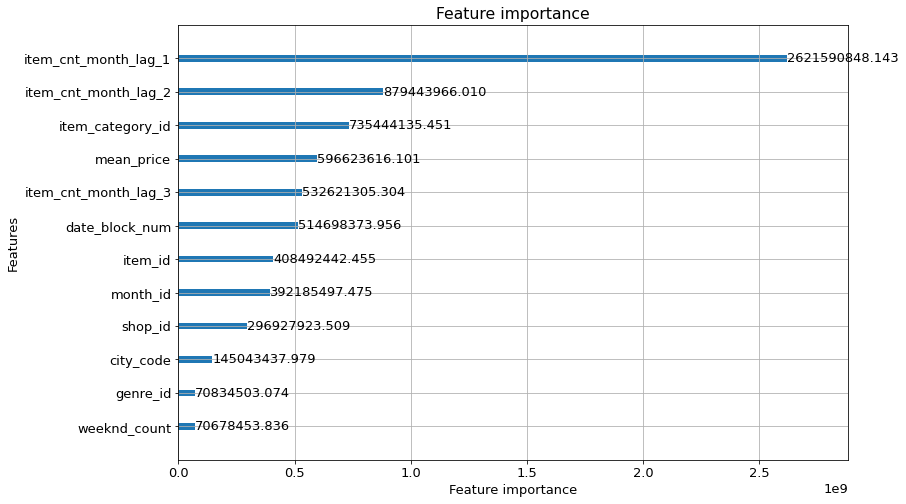

In [47]:
# plot feature significance to training
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [48]:
# predict & export submissions
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)



submission = pd.DataFrame({ "ID": test.index, "item_cnt_month": Y_test }) 
submission.to_csv('gbm_submissionXYZZ.csv', index=False)

In [49]:
print(len(Y_test))

214200


In [50]:
print(len(test))

214200


In [51]:
test.head()


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [52]:
print(Y_test)


[3.64375285 4.55343167 3.74986947 ... 1.80931208 1.75640511 1.51465895]


In [53]:

print(len(X_test))

214200
